In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

base_path = '.'

In [2]:
# Modify csv to follow same pattern

# Content based
# results_uwarm_iwarm = pd.read_csv(f'{base_path}\\content-based\\content-based_warm_user_warm_item.csv', usecols=['RatingID', 'PredictedRating'])
# results_uwarm_icold = pd.read_csv(f'{base_path}\\content-based\\content-based_warm_user_cold_item.csv', usecols=['RatingID', 'PredictedRating'])
# results_ucold_uwarm = pd.read_csv(f'{base_path}\\content-based\\content-based_cold_user_warm_item.csv', usecols=['RatingID', 'PredictedRating'])
# results_ucold_icold = pd.read_csv(f'{base_path}\\content-based\\content-based_cold_user_cold_item.csv', usecols=['RatingID', 'PredictedRating'])
# results_uwarm_iwarm.to_csv(f'{base_path}\\content-based\\content-based_warm_user_warm_item.csv', index=False, header=['RatingID', 'Rating'])
# results_uwarm_icold.to_csv(f'{base_path}\\content-based\\content-based_warm_user_cold_item.csv', index=False, header=['RatingID', 'Rating'])
# results_ucold_uwarm.to_csv(f'{base_path}\\content-based\\content-based_cold_user_warm_item.csv', index=False, header=['RatingID', 'Rating'])
# results_ucold_icold.to_csv(f'{base_path}\\content-based\\content-based_cold_user_cold_item.csv', index=False, header=['RatingID', 'Rating'])

# Graph based
# results_uwarm_iwarm = pd.read_csv(f'{base_path}\\graph-sage\\graph-sage_warm_user_warm_item.csv', usecols=['RatingID', 'Rating_Pred_Tensor'])
# results_uwarm_icold = pd.read_csv(f'{base_path}\\graph-sage\\graph-sage_warm_user_cold_item.csv', usecols=['RatingID', 'Rating_Pred_Tensor'])
# results_ucold_uwarm = pd.read_csv(f'{base_path}\\graph-sage\\graph-sage_cold_user_warm_item.csv', usecols=['RatingID', 'Rating_Pred_Tensor'])
# results_ucold_icold = pd.read_csv(f'{base_path}\\graph-sage\\graph-sage_cold_user_cold_item.csv', usecols=['RatingID', 'Rating_Pred_Tensor'])
# results_uwarm_iwarm.to_csv(f'{base_path}\\graph-sage\\graph-sage_warm_user_warm_item.csv', index=False, header=['RatingID', 'Rating'])
# results_uwarm_icold.to_csv(f'{base_path}\\graph-sage\\graph-sage_warm_user_cold_item.csv', index=False, header=['RatingID', 'Rating'])
# results_ucold_uwarm.to_csv(f'{base_path}\\graph-sage\\graph-sage_cold_user_warm_item.csv', index=False, header=['RatingID', 'Rating'])
# results_ucold_icold.to_csv(f'{base_path}\\graph-sage\\graph-sage_cold_user_cold_item.csv', index=False, header=['RatingID', 'Rating'])

In [3]:

def evaluate_topk_fast(df, k=10):
    # Pre-sort so top-k is at the top per user
    df = df.sort_values(['UserID', 'Rank_pred'], ascending=[True, True])

    # Assign group index per row (unique integer per user)
    user_index, user_pos = np.unique(df['UserID'], return_inverse=True)

    # Count items per user
    user_counts = np.bincount(user_pos)
    user_offsets = np.zeros(len(df), dtype=int)
    np.add.at(user_offsets, np.cumsum(user_counts)[:-1], 1)
    user_offsets = np.cumsum(user_offsets)

    # Mask to keep only top-k per user
    df['row_number'] = df.groupby('UserID').cumcount()
    topk_df = df[df['row_number'] < k].copy()

    # Precision@k
    precision = topk_df['Relevance'].groupby(topk_df['UserID']).mean().mean()

    # Recall@k
    relevant_per_user = df.groupby('UserID')['Relevance'].sum()
    hits_per_user = topk_df.groupby('UserID')['Relevance'].sum()
    recall = (hits_per_user / relevant_per_user).fillna(0).mean()

    # HitRate@k
    hits = (hits_per_user > 0).astype(int)
    hit_rate = hits.mean()

    # nDCG@k
    def dcg(rels):
        return np.sum(rels / np.log2(np.arange(2, len(rels) + 2)))
    def ndcg_per_user(x):
        dcg_val = dcg(x['Relevance'].values)
        ideal = x.sort_values('Relevance', ascending=False).head(k)
        idcg_val = dcg(ideal['Relevance'].values)
        return dcg_val / idcg_val if idcg_val > 0 else 0
    ndcg = topk_df.groupby('UserID').apply(ndcg_per_user, include_groups=False).mean()

    return {
        f'Precision@{k}': precision,
        f'Recall@{k}': recall,
        f'HitRate@{k}': hit_rate,
        f'nDCG@{k}': ndcg
    }

In [4]:
# Load the test sets
print('Loading test sets...')
test_uwarm_iwarm = pd.read_csv(f'{base_path}\\testset_warm_user_warm_item.csv', usecols=['RatingID', 'UserID', 'WineID', 'Rating'])
test_uwarm_icold = pd.read_csv(f'{base_path}\\testset_warm_user_cold_item.csv', usecols=['RatingID', 'UserID', 'WineID', 'Rating'])
test_ucold_iwarm = pd.read_csv(f'{base_path}\\testset_cold_user_warm_item.csv', usecols=['RatingID', 'UserID', 'WineID', 'Rating'])
test_ucold_icold = pd.read_csv(f'{base_path}\\testset_cold_user_cold_item.csv', usecols=['RatingID', 'UserID', 'WineID', 'Rating'])

# Models
models = ['content-based', 'svd', 'hybrid-lgbm', 'hybrid-xgb', 'graph-sage']
# Test set types
testsets = ['hot user, hot wine', 'hot user, cold wine', 'cold user, hot wine', 'cold user, cold wine']

k = 10
relevance_threshold = 3.5
results = {}

for model in models:
    results[model] = {
        'regression': {
            'mse': {},
            'rmse': {},
            'mae': {}
            },
        'top-k': {
            'precision': {},
            'recall': {},
            'hitrate': {},
            'ndcg': {}
            }
        }
    
    # Load the results for each test set
    print(f'Loading results for {model}...')

    results_uwarm_iwarm = pd.read_csv(f'{base_path}\\{model}\\{model}_warm_user_warm_item.csv', header= 0, names=['RatingID','Rating_pred'])
    results_uwarm_icold = pd.read_csv(f'{base_path}\\{model}\\{model}_warm_user_cold_item.csv', header= 0, names=['RatingID','Rating_pred'])
    results_ucold_iwarm = pd.read_csv(f'{base_path}\\{model}\\{model}_cold_user_warm_item.csv', header= 0, names=['RatingID','Rating_pred'])
    results_ucold_icold = pd.read_csv(f'{base_path}\\{model}\\{model}_cold_user_cold_item.csv', header= 0, names=['RatingID','Rating_pred'])
    
    # Merge the results with the test set
    print('Merging results with test set...')
    results_uwarm_iwarm = results_uwarm_iwarm.merge(test_uwarm_iwarm, on='RatingID', how='left')
    results_uwarm_icold = results_uwarm_icold.merge(test_uwarm_icold, on='RatingID', how='left')
    results_ucold_iwarm = results_ucold_iwarm.merge(test_ucold_iwarm, on='RatingID', how='left')
    results_ucold_icold = results_ucold_icold.merge(test_ucold_icold, on='RatingID', how='left')
    
    # Calculate the MSE, RMSE and MAE for each test set
    print('Calculating MSE, RMSE and MAE...')
    # Hot user, hot wine
    results[model]['regression']['mse'][testsets[0]] = mean_squared_error(results_uwarm_iwarm['Rating'], results_uwarm_iwarm['Rating_pred'])
    results[model]['regression']['rmse'][testsets[0]] = root_mean_squared_error(results_uwarm_iwarm['Rating'], results_uwarm_iwarm['Rating_pred'])
    results[model]['regression']['mae'][testsets[0]] = mean_absolute_error(results_uwarm_iwarm['Rating'], results_uwarm_iwarm['Rating_pred'])
    # Hot user, cold wine
    results[model]['regression']['mse'][testsets[1]] = mean_squared_error(results_uwarm_icold['Rating'], results_uwarm_icold['Rating_pred'])
    results[model]['regression']['rmse'][testsets[1]] = root_mean_squared_error(results_uwarm_icold['Rating'], results_uwarm_icold['Rating_pred'])
    results[model]['regression']['mae'][testsets[1]] = mean_absolute_error(results_uwarm_icold['Rating'], results_uwarm_icold['Rating_pred'])
    # Cold user, hot wine
    results[model]['regression']['mse'][testsets[2]] = mean_squared_error(results_ucold_iwarm['Rating'], results_ucold_iwarm['Rating_pred'])
    results[model]['regression']['rmse'][testsets[2]] = root_mean_squared_error(results_ucold_iwarm['Rating'], results_ucold_iwarm['Rating_pred'])
    results[model]['regression']['mae'][testsets[2]] = mean_absolute_error(results_ucold_iwarm['Rating'], results_ucold_iwarm['Rating_pred'])
    # Cold user, cold wine
    results[model]['regression']['mse'][testsets[3]] = mean_squared_error(results_ucold_icold['Rating'], results_ucold_icold['Rating_pred'])
    results[model]['regression']['rmse'][testsets[3]] = root_mean_squared_error(results_ucold_icold['Rating'], results_ucold_icold['Rating_pred'])
    results[model]['regression']['mae'][testsets[3]] = mean_absolute_error(results_ucold_icold['Rating'], results_ucold_icold['Rating_pred'])
    
    # Create Rank, Rank_pred and Relevance columns
    print('Creating Rank, Rank_pred and Relevance columns...')
    # Warm user, warm item
    results_uwarm_iwarm["Rank"] = results_uwarm_iwarm.groupby("UserID")["Rating"].rank(method="first", ascending=False)
    results_uwarm_iwarm["Rank_pred"] = results_uwarm_iwarm.groupby("UserID")["Rating_pred"].rank(method="first", ascending=False)
    # Warm user, cold item
    results_uwarm_icold["Rank"] = results_uwarm_icold.groupby("UserID")["Rating"].rank(method="first", ascending=False)
    results_uwarm_icold["Rank_pred"] = results_uwarm_icold.groupby("UserID")["Rating_pred"].rank(method="first", ascending=False)
    # Cold user, warm item
    results_ucold_iwarm["Rank"] = results_ucold_iwarm.groupby("UserID")["Rating"].rank(method="first", ascending=False)
    results_ucold_iwarm["Rank_pred"] = results_ucold_iwarm.groupby("UserID")["Rating_pred"].rank(method="first", ascending=False)
    # Cold user, cold item
    results_ucold_icold["Rank"] = results_ucold_icold.groupby("UserID")["Rating"].rank(method="first", ascending=False)
    results_ucold_icold["Rank_pred"] = results_ucold_icold.groupby("UserID")["Rating_pred"].rank(method="first", ascending=False)

    # Calculate Relevance
    results_uwarm_iwarm["Relevance"] = results_uwarm_iwarm["Rating"].apply(lambda x: 1 if x >= relevance_threshold else 0)
    results_uwarm_icold["Relevance"] = results_uwarm_icold["Rating"].apply(lambda x: 1 if x >= relevance_threshold else 0)
    results_ucold_iwarm["Relevance"] = results_ucold_iwarm["Rating"].apply(lambda x: 1 if x >= relevance_threshold else 0)
    results_ucold_icold["Relevance"] = results_ucold_icold["Rating"].apply(lambda x: 1 if x >= relevance_threshold else 0)
    
    # Calculate the precision, recall, hitrate and ndcg for each test set
    # Hot user, hot wine
    print(f'Calculating precision, recall, hitrate and ndcg for {model}/{testsets[0]}...')
    results[model]['top-k']['precision'][testsets[0]] = evaluate_topk_fast(results_uwarm_iwarm, k=k)[f'Precision@{k}']
    results[model]['top-k']['recall'][testsets[0]] = evaluate_topk_fast(results_uwarm_iwarm, k=k)[f'Recall@{k}']
    results[model]['top-k']['hitrate'][testsets[0]] = evaluate_topk_fast(results_uwarm_iwarm, k=k)[f'HitRate@{k}']
    results[model]['top-k']['ndcg'][testsets[0]] = evaluate_topk_fast(results_uwarm_iwarm, k=k)[f'nDCG@{k}']
    # Hot user, cold wine
    print(f'Calculating precision, recall, hitrate and ndcg for {model}/{testsets[1]}...')
    results[model]['top-k']['precision'][testsets[1]] = evaluate_topk_fast(results_uwarm_icold, k=k)[f'Precision@{k}']
    results[model]['top-k']['recall'][testsets[1]] = evaluate_topk_fast(results_uwarm_icold, k=k)[f'Recall@{k}']
    results[model]['top-k']['hitrate'][testsets[1]] = evaluate_topk_fast(results_uwarm_icold, k=k)[f'HitRate@{k}']
    results[model]['top-k']['ndcg'][testsets[1]] = evaluate_topk_fast(results_uwarm_icold, k=k)[f'nDCG@{k}']
    # Cold user, hot wine
    print(f'Calculating precision, recall, hitrate and ndcg for {model}/{testsets[2]}...')
    results[model]['top-k']['precision'][testsets[2]] = evaluate_topk_fast(results_ucold_iwarm, k=k)[f'Precision@{k}']
    results[model]['top-k']['recall'][testsets[2]] = evaluate_topk_fast(results_ucold_iwarm, k=k)[f'Recall@{k}']
    results[model]['top-k']['hitrate'][testsets[2]] = evaluate_topk_fast(results_ucold_iwarm, k=k)[f'HitRate@{k}']
    results[model]['top-k']['ndcg'][testsets[2]] = evaluate_topk_fast(results_ucold_iwarm, k=k)[f'nDCG@{k}']
    # Cold user, cold wine
    print(f'Calculating precision, recall, hitrate and ndcg for {model}/{testsets[3]}...')
    results[model]['top-k']['precision'][testsets[3]] = evaluate_topk_fast(results_ucold_icold, k=k)[f'Precision@{k}']
    results[model]['top-k']['recall'][testsets[3]] = evaluate_topk_fast(results_ucold_icold, k=k)[f'Recall@{k}']
    results[model]['top-k']['hitrate'][testsets[3]] = evaluate_topk_fast(results_ucold_icold, k=k)[f'HitRate@{k}']
    results[model]['top-k']['ndcg'][testsets[3]] = evaluate_topk_fast(results_ucold_icold, k=k)[f'nDCG@{k}']
    print('-' * 50)


Loading test sets...
Loading results for content-based...
Merging results with test set...
Calculating MSE, RMSE and MAE...
Creating Rank, Rank_pred and Relevance columns...
Calculating precision, recall, hitrate and ndcg for content-based/hot user, hot wine...
Calculating precision, recall, hitrate and ndcg for content-based/hot user, cold wine...
Calculating precision, recall, hitrate and ndcg for content-based/cold user, hot wine...
Calculating precision, recall, hitrate and ndcg for content-based/cold user, cold wine...
--------------------------------------------------
Loading results for svd...
Merging results with test set...
Calculating MSE, RMSE and MAE...
Creating Rank, Rank_pred and Relevance columns...
Calculating precision, recall, hitrate and ndcg for svd/hot user, hot wine...
Calculating precision, recall, hitrate and ndcg for svd/hot user, cold wine...
Calculating precision, recall, hitrate and ndcg for svd/cold user, hot wine...
Calculating precision, recall, hitrate a

In [12]:
# Dict to DataFrame
rows = []
for model, metrics in results.items():
    for metric_type, values in metrics.items():
        for metric, testset_values in values.items():
            for testset, value in testset_values.items():
                row = {
                    'Model': model,
                    'Testset': testset,
                    'Metric Type': metric_type,
                    'Metric': metric,
                    'Value': value
                }
                
                rows.append(row)
                
df_results = pd.DataFrame(rows, columns=['Model', 'Testset', 'Metric Type', 'Metric', 'Value'])
df_results.to_csv(f'{base_path}\\results.csv', index=False)
        




In [14]:
# Load the data
df = pd.read_csv(f'{base_path}\\results.csv')

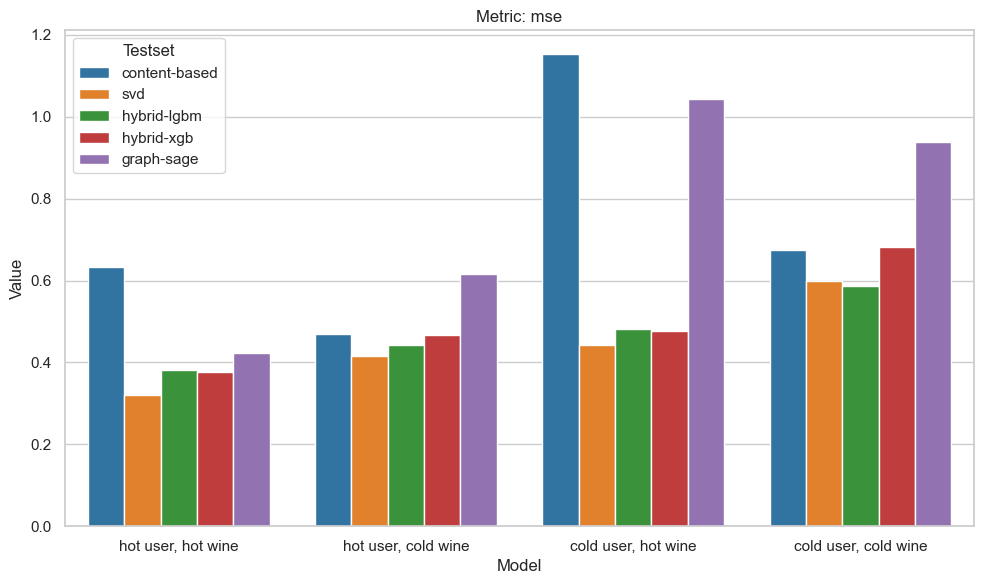

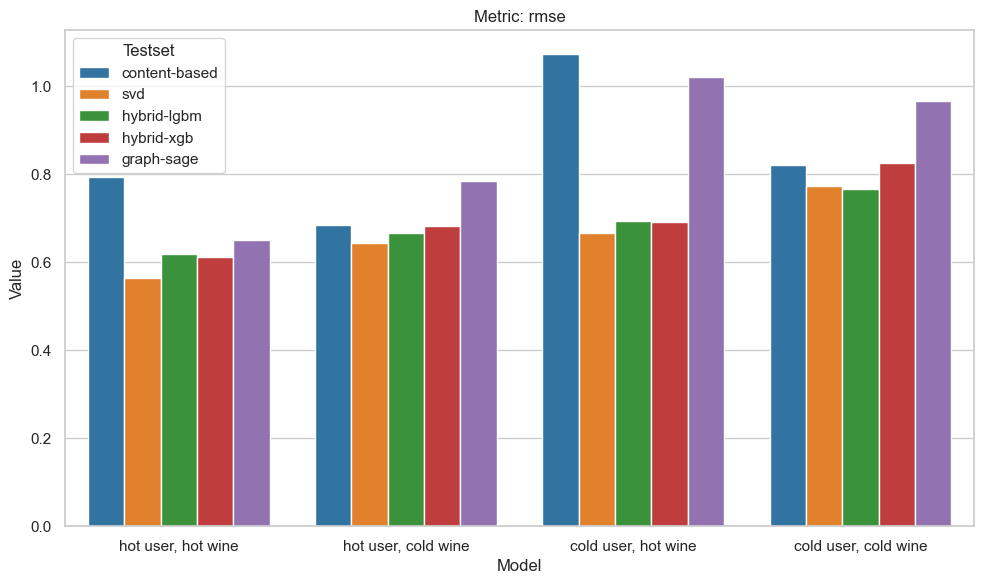

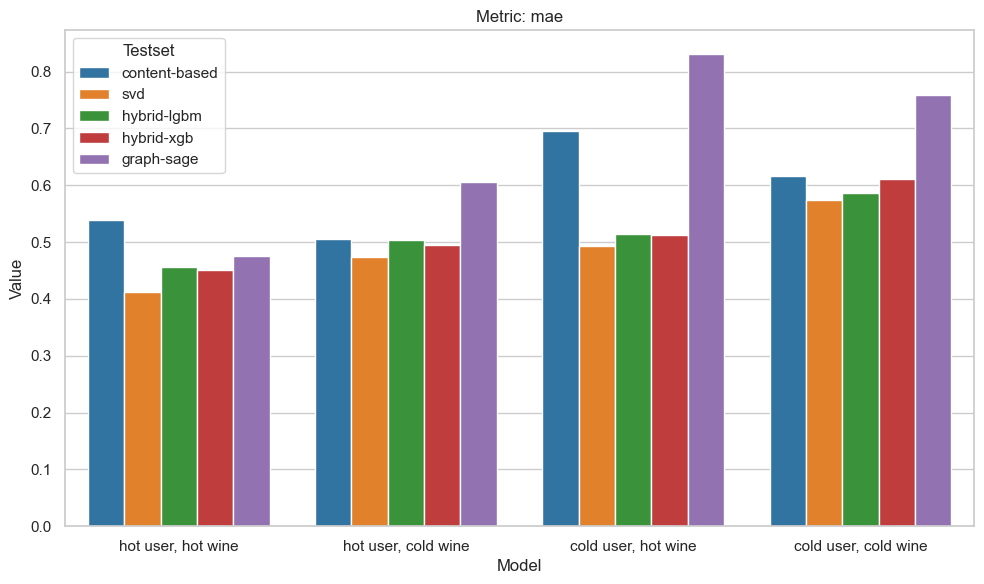

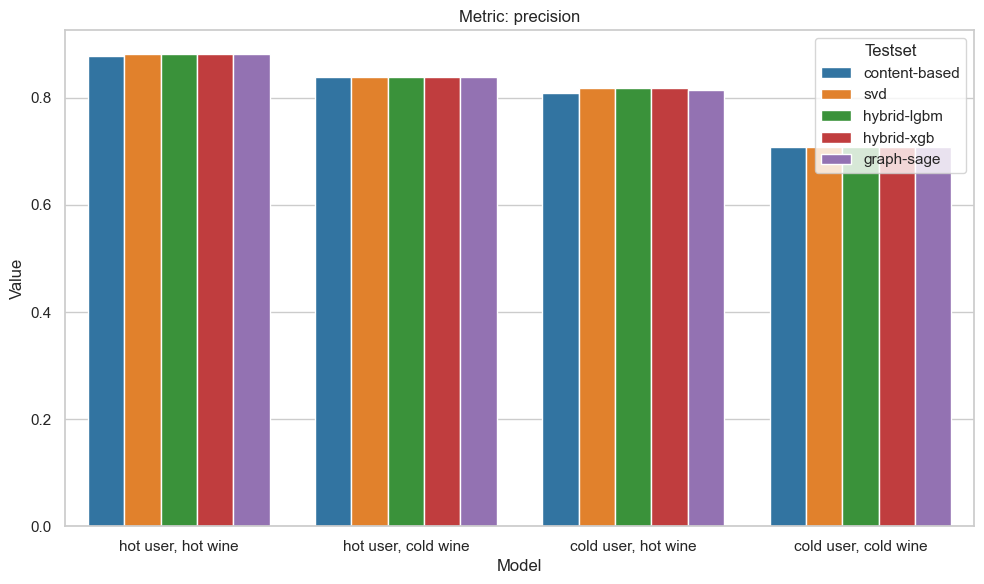

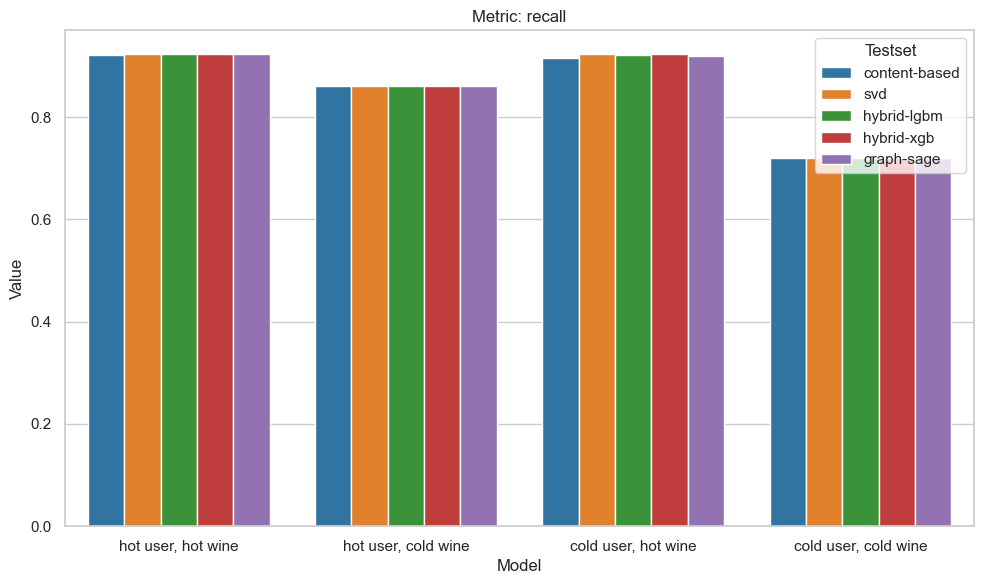

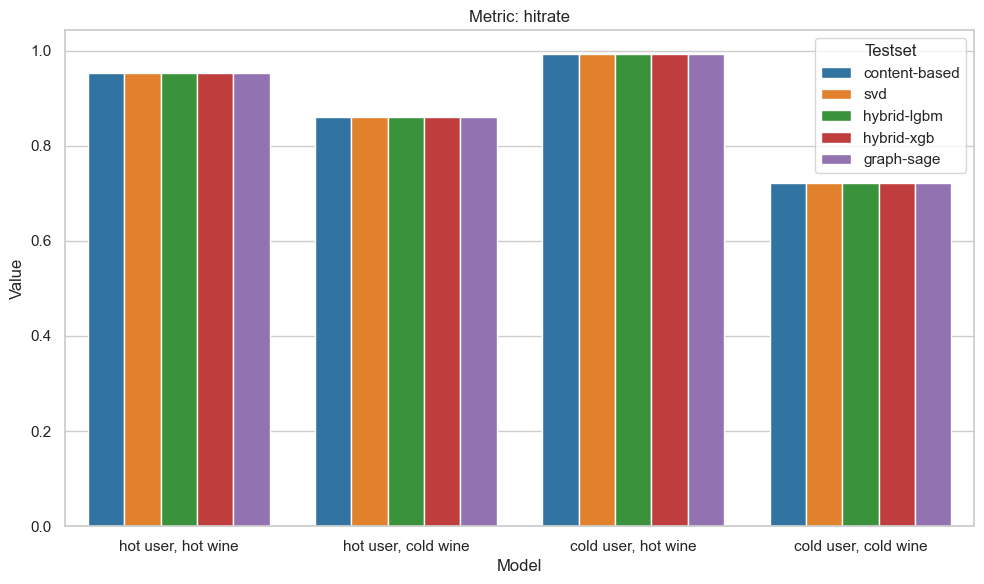

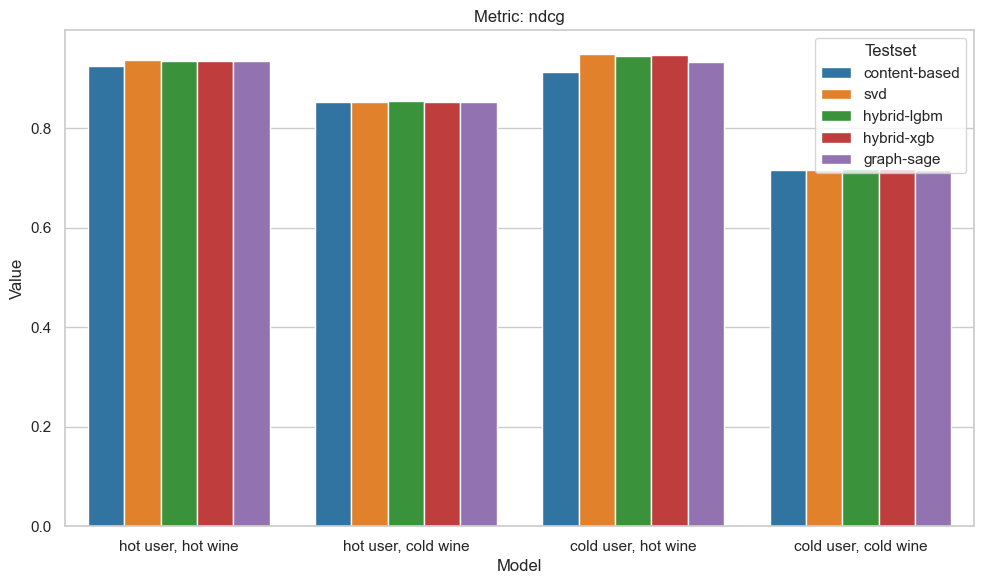

In [ ]:
# Set the visual style
sns.set(style="whitegrid")

# Create plots for each unique Metric
for metric in df['Metric'].unique():
    plt.figure(figsize=(10, 6))
    metric_df = df[df['Metric'] == metric]
    
    ax = sns.barplot(
        data=metric_df,
        x='Testset',
        y='Value',
        hue='Model',
        palette='tab10'
    )
    
    plt.title(f'Metric: {metric}')
    plt.ylabel('Value')
    plt.xlabel('Model')
    plt.legend(title='Testset')
    plt.tight_layout()
    plt.show()

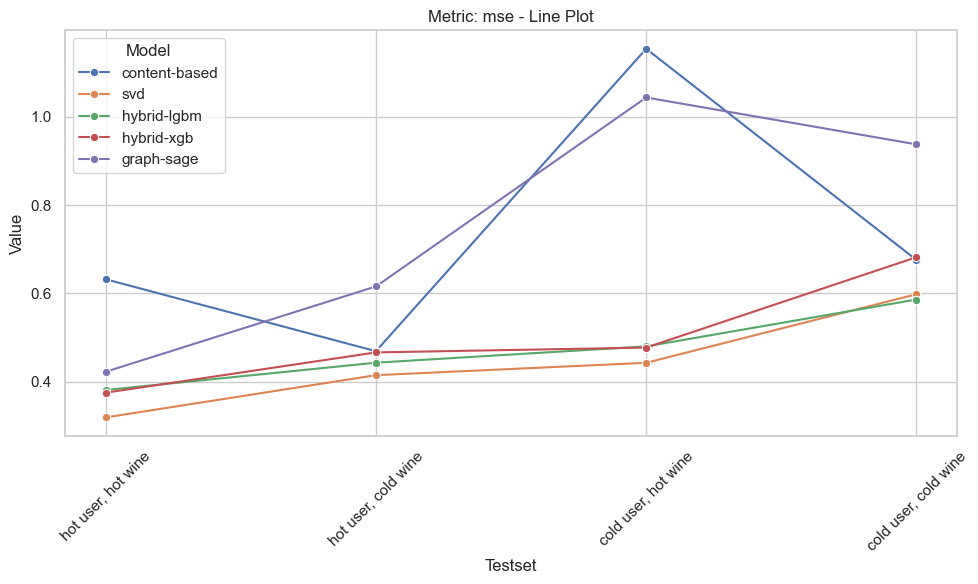

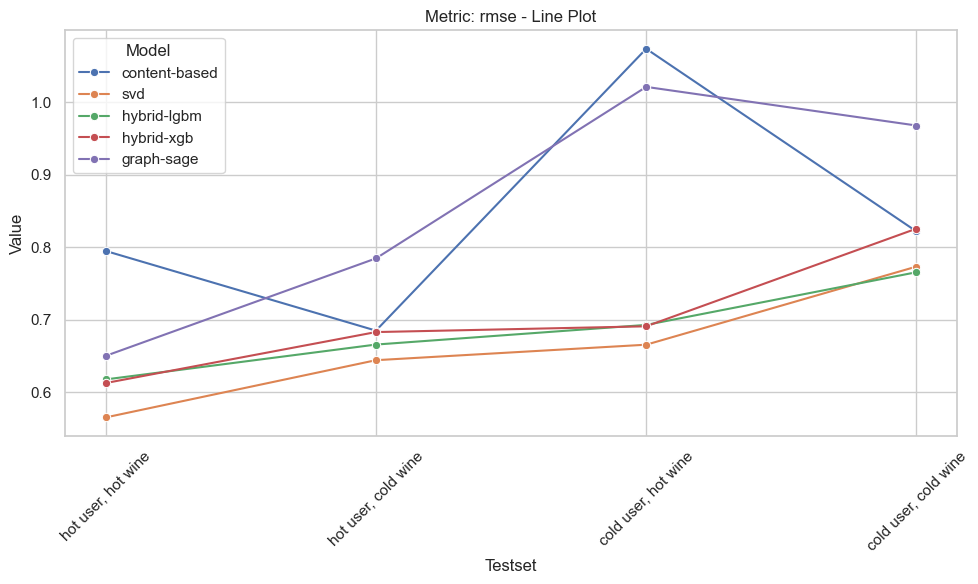

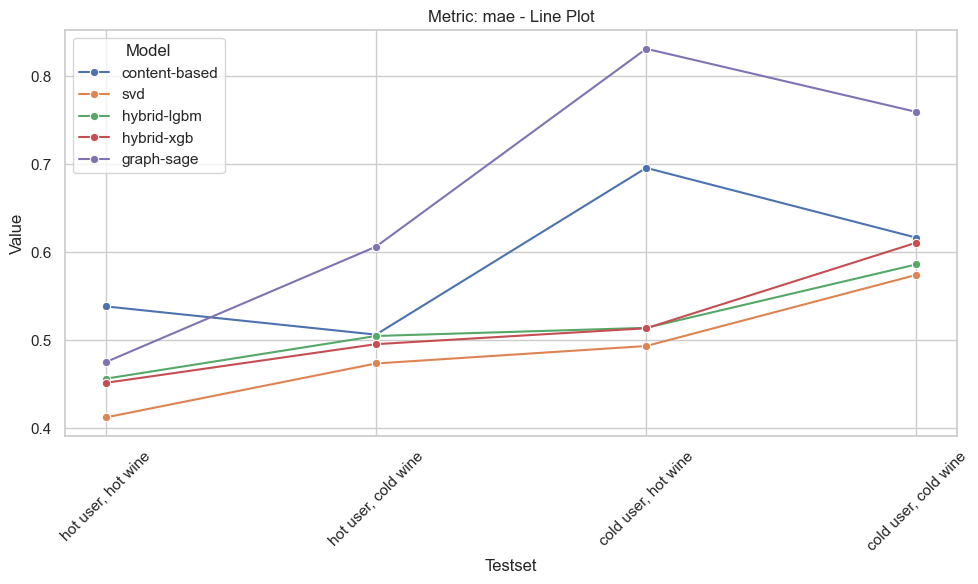

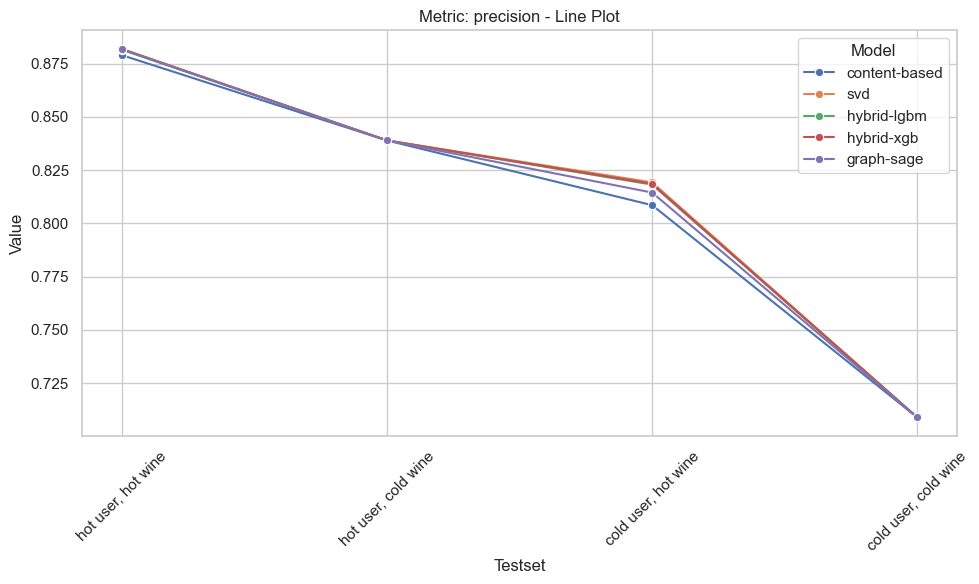

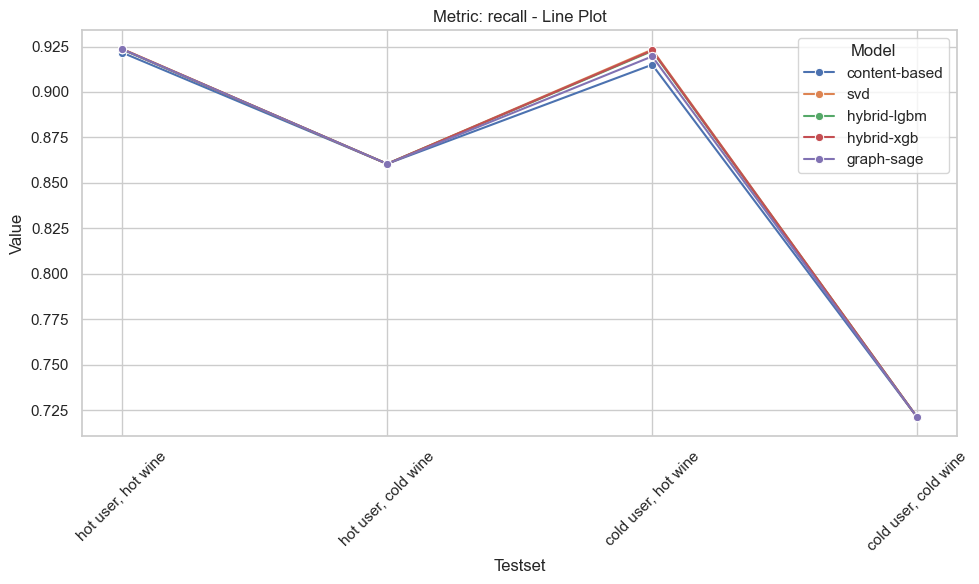

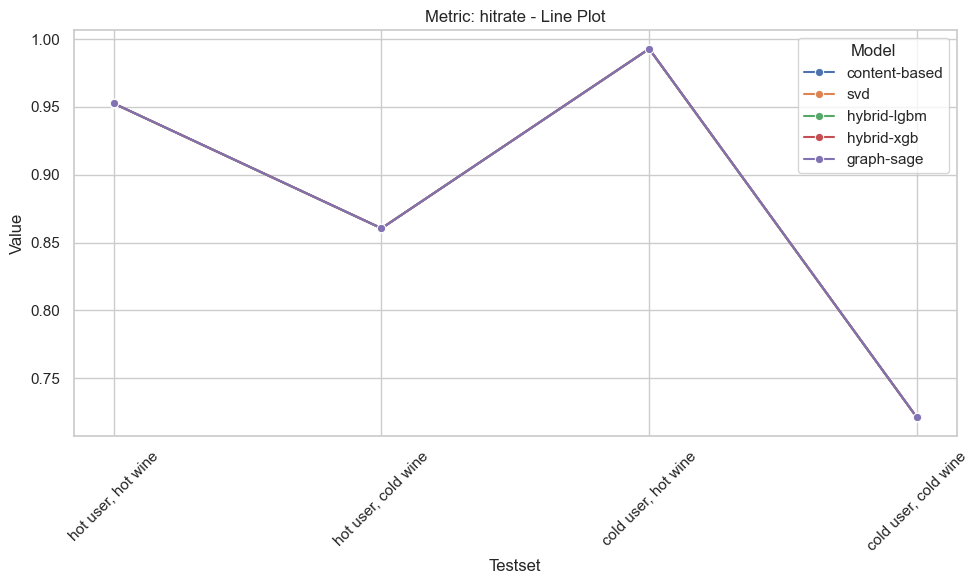

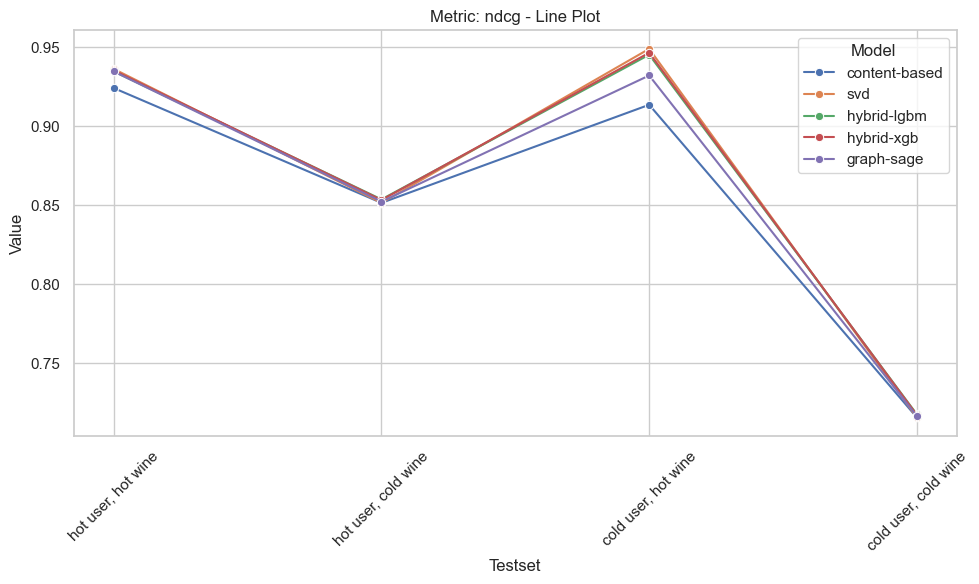

In [18]:
for metric in df['Metric'].unique():
    metric_df = df[df['Metric'] == metric]
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=metric_df, x='Testset', y='Value', hue='Model', marker='o')
    plt.title(f'Metric: {metric} - Line Plot')
    plt.xticks(rotation=45)
    plt.ylabel('Value')
    plt.tight_layout()
    plt.show()
